# testing poverty rate correlations

https://www.census.gov/data/datasets/2019/demo/saipe/2019-state-and-county.html

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


In [137]:
poverty = pd.read_csv('fips_poverty_est.csv')
poverty = poverty[['State FIPS Code', 'County FIPS Code', 'Poverty Percent, Age 5-17 in Families']]
poverty['statefips'] = [str(n).zfill(2) for n in poverty['State FIPS Code']]
poverty['countyfips'] = [str(n).zfill(3) for n in poverty['County FIPS Code']]
poverty['fips'] = [f'{s}{c}' for i,s,c in poverty[['statefips', 'countyfips']].itertuples()]
poverty = poverty[poverty['fips'].isin(raw['fips'].unique())]
poverty = poverty[['fips', 'Poverty Percent, Age 5-17 in Families']]
poverty.columns = ['fips', 'poverty_estimate']
poverty['poverty_estimate'] = poverty['poverty_estimate'].replace(',','', regex = True)
raw = pd.merge(raw, poverty, on='fips')
raw['poverty_estimate'] = raw['poverty_estimate'].astype(float)
raw.head()


,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count,poverty_estimate
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,7,07:03:44,7,0,1,Nevada,NV,32003,1,17.6
1,id:1226773799342706689,2020-02-10 07:44:00+00:00,312.0,125.0,32.0,3.0,Clark,1,sadly nothing will be done to help the people ...,sadly help people china communist government u...,...,7,07:44:00,7,1,0,Nevada,NV,32003,1,17.6
2,id:1226327068389998592,2020-02-09 02:08:51+00:00,2887.0,831.0,32.0,3.0,Clark,1,the world is grieving for the wuhan doctor who...,world grieving wuhan doctor try warn colleague...,...,6,02:08:51,2,1,0,Nevada,NV,32003,1,17.6
3,id:1233697011758587907,2020-02-29 10:14:23+00:00,7.0,169.0,32.0,3.0,Clark,1,risk of global coronavirus spread very high wa...,risk global coronavirus spread high warn china...,...,9,10:14:23,10,1,0,Nevada,NV,32003,1,17.6
4,id:1233697205405437953,2020-02-29 10:15:09+00:00,7.0,169.0,32.0,3.0,Clark,1,coronavirus what are the chances of dying,coronavirus chances die,...,9,10:15:09,10,1,0,Nevada,NV,32003,1,17.6


In [138]:
keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')

there are a total of 53215 tweets after subsetting for cdc keywords


909
                    count  is_negative  poverty_estimate
count             1.00000     0.001360          0.000600
is_negative       0.00136     1.000000          0.006038
poverty_estimate  0.00060     0.006038          1.000000
(0.07770310017327457, 0.019127376790037905)


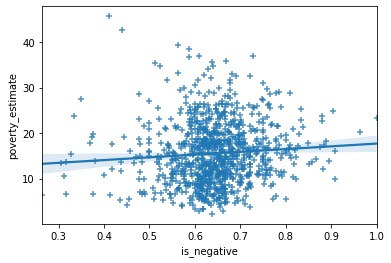

In [146]:
counties = raw.groupby(['fips']).agg({'count':'count', 'is_negative':'mean', 'poverty_estimate':'mean'}).reset_index()
counties = counties[counties['count'] > 15]
print(len(counties.index))
print(counties.corr()**2)

import scipy

x= counties['is_negative']
y= counties['poverty_estimate']

print(scipy.stats.pearsonr(x, y))

sns.regplot(y='poverty_estimate', x='is_negative', data=counties, marker='+')

                     count  is_negative  poverty_estimate
count             1.000000     0.001010          0.009812
is_negative       0.001010     1.000000          0.000002
poverty_estimate  0.009812     0.000002          1.000000
(0.0015243020315552584, 0.9753623631086268)


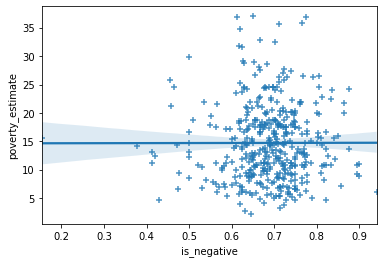

In [143]:
counties = cdc.groupby(['fips']).agg({'count':'count', 'is_negative':'mean', 'poverty_estimate':'mean'}).reset_index()
counties = counties[counties['count'] > 15]

print(counties.corr()**2)

# import scipy

x= counties['is_negative']
y= counties['poverty_estimate']

print(scipy.stats.pearsonr(x, y))

sns.regplot(y='poverty_estimate', x='is_negative', data=counties, marker='+')